# LASSO Optimization: FISTA and Adaptive Proximal Gradient Methods

This notebook implements and analyzes two optimization methods for solving the LASSO problem:

$$
\min_{x \in \mathbb{R}^n} \|Ax - b\|_2^2 + \lambda\|x\|_1
$$

where:
- $A \in \mathbb{R}^{m \times n}$ $(m=100, n=1000)$
- $b \in \mathbb{R}^m$
- $\lambda = \|A^T b\|_{\infty}/10$

We implement and compare:
1. FISTA with constant stepsize (Beck & Teboulle, 2009)
2. Adaptive Proximal Gradient Method (Malitsky & Mishchenko, 2024)

The implementation includes:
- Generation of problem data using standard Gaussian distribution
- Visualization of convergence behavior
- Analysis of theoretical guarantees

## Prerequisites

### Imports

In [1]:
# Code Cell: Data Generation
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp


# Set random seed for reproducibility
np.random.seed(42)


### Data specifications


In [2]:
m = 100
n = 1000

# Generate matrix A and vector b with standard Gaussian entries
A = np.random.randn(m, n)
b = np.random.randn(m)

# Set lambda = ||A^\top b||_infty / 10
lambda_reg = np.linalg.norm(A.T @ b, ord=np.inf) / 10

## FISTA
### The algorithm
The FISTA with constant stepsize algorithm looks as follows:

<div style="border: 2px solid black; padding: 10px; background-color: #f9f9f9;">
    
**Input:** $L = L(f)$ - A Lipschitz constant of $\nabla f$

**Step 0:** Take $y_1 = x_0 \in \mathbb{R}^n, t_1 = 1$

**For** $k \geq 1$, compute:

$$
\mathbf{x}_k = p_L(\mathbf{y}_k) 
$$

$$
t_{k+1} = \frac{1 + \sqrt{1 + 4t_k^2}}{2} 
$$

$$
\mathbf{y}_{k+1} = \mathbf{x}_k + \left( \frac{t_k - 1}{t_{k+1}} \right) (\mathbf{x}_k - \mathbf{x}_{k-1}) 
$$
</div>
    
There are essentially two things here that needs to be figured out. First we need to find the Lipschitz constant of $\nabla f$ (or in other words $\beta$ for $\beta$-Smoothness of $f$). Also we need to figure out what $p_L(\mathbf{y}_k)$ comes out to be. 

### The Lipschitz Constant
We recall that the problem in question is:

$$
\underset{x \in \mathbb{R}^n}{\text{minimize}} \ F(x) = \underset{x \in \mathbb{R}^n}{\text{minimize}} \ f(x) + g(x),
$$

with $f(x) = \|Ax - b\|_2^2$ and  $g(x) = \lambda \|x\|_1$, which indeed is the problem considered in the FISTA paper. Let us find $L$. First note that $f(x) = \|Ax - b\|_2^2 = (Ax-b)^\top (Ax - b)$, meaning that $\nabla f(x) = 2A^\top(Ax - b)$. Therefore we have

$$
\begin{align*}
\|\nabla f(x) - \nabla f(y)\|_2 &= \|2A^\top(Ax - b) - 2A^\top(Ay - b)\|_2 \\
&= \|2A^\top(Ax - Ay)\|_2 \\
&= \|2A^\top A(x - y)\|_2 \\
&\leq 2\|A^\top A\|_2 \|x - y\|_2
\end{align*}
$$

Thus, $L = 2\|A^\top A\|_2 $ is a Lipschitz constant of $\nabla f$. We also recall that $\|A^\top A\|_2 = \|A\|_2^2 = \lambda_{\text{max}}(A^\top A)$ implying that 

$$
L = 2\|A^\top A\|_2= 2\|A\|_2^2=2 \lambda_{\text{max}}[A^\top A] = 2 \sigma_{\text{max}}(A)^2,
$$

where $\sigma_{\text{max}}(A)$ represents the largest singular value of matrix $A$.

### The proximal operator
In the paper they define and derive $p_L(\mathbf{y}_k)$ as follows: consider the quadratic approximation model for any $L > 0$ to approximate the function $F(x) := f(x) + g(x)$ at a given point $y$:

$$
Q_L(x, y) := f(y) + \langle x - y, \nabla f(y) \rangle + \frac{L}{2} \|x - y\|^2 + g(x),
$$

which admits a unique minimizer:

$$
p_L(y) := \arg\min \{Q_L(x, y) : x \in \mathbb{R}^n\}.
$$

After performing simple algebra and ignoring constant terms in $y$, the expression for $p_L(y)$ becomes:

$$
p_L(y) = \arg\min_x \left\{ g(x) + \frac{L}{2} \left\| x - \left( y - \frac{1}{L} \nabla f(y) \right) \right\|^2 \right\}.
$$

They do not explicitly mention it in the paper, but it is evident that this is precisely the proximal opreator evaluated at 
$y-\frac{1}{L} \nabla f(y)$, i.e

$$
p_L(y) = \text{prox}_{L^{-1}g}\left(y-L^{-1}\nabla f\left(y\right)\right).
$$

We know already that for $g(x) = \lambda \left\| x \right\|_1$ the proximal operator is given as

$$
\text{prox}_{\gamma g}(z)=
    \begin{bmatrix}
    \operatorname{sign}(z_1) \cdot \max\left( |z_1| - \lambda\gamma,\, 0 \right) \\
    \vdots \\
    \operatorname{sign}(z_n) \cdot \max\left( |z_n| - \lambda\gamma,\, 0 \right)
    \end{bmatrix},
$$

where $z =(z_1, \dots, z_n)$, for example see week 4 bonus problem. This is what the authors of the paper call the "shrinkage" operator.

### Helpers
Let use define some helper functions needed in the FISTA implementation.

In [3]:
def grad_f(x, A, b):
    """
    Compute the gradient of f(x) = ||Ax - b||_2^2.

    Args:
    x (ndarray): Current point.
    A (ndarray): Design matrix.
    b (ndarray): Target vector.

    Returns:
    ndarray: Gradient of f at x.
    """
    return 2 * A.T @ (A @ x - b)

def lipschitz(A):
    """
    Compute Lipschitz constant of gradient of f(x) = ||Ax - b||_2^2.

    Args:
    A (ndarray): Design matrix.

    Returns:
    float: Lipschitz constant L.
    """
    singular_values = np.linalg.svd(A, compute_uv=False)
    return 2 * (singular_values[0]) ** 2  # First singular value is largest

def prox_g(z, gamma, lambda_reg):
    """
    Compute proximal operator of g(x) = λ||x||_1 (soft-thresholding).

    Args:
    z (ndarray): Input point.
    gamma (float): Step size.
    lambda_reg (float): Regularization parameter.

    Returns:
    ndarray: Result of proximal operator.
    """
    return np.sign(z) * np.maximum(np.abs(z) - lambda_reg * gamma, 0)

def compute_F(x, A, b, lambda_reg):
    """
    Compute LASSO objective F(x) = ||Ax - b||_2^2 + λ||x||_1.

    Args:
    x (ndarray): Input point.
    A (ndarray): Design matrix.
    b (ndarray): Target vector.
    lambda_reg (float): Regularization parameter.

    Returns:
    float: Objective function value.
    """
    return np.linalg.norm(A @ x - b, 2)**2 + lambda_reg * np.linalg.norm(x, 1)

def solve_cvxpy(A, b, lambda_reg):
    """
    Solve LASSO problem using CVXPY.

    Args:
    A (ndarray): Design matrix.
    b (ndarray): Target vector.
    lambda_reg (float): Regularization parameter.

    Returns:
    ndarray: Optimal solution x*.
    """
    n = A.shape[1]
    x = cp.Variable(n)
    objective = cp.Minimize(cp.norm2(A @ x - b)**2 + lambda_reg * cp.norm1(x))
    problem = cp.Problem(objective)
    problem.solve(solver=cp.ECOS, abstol=1e-16, reltol=1e-16, max_iters=100000)
    return x.value

def track_suboptimality(F_trajectory, x_opt, A, b, lambda_reg):
    """
    Calculate and track the suboptimality during the optimization process.

    This function computes two measures of algorithm performance:
    1. The actual suboptimality at each iteration.
    2. The best (lowest) suboptimality achieved up to each iteration.

    Args:
    F_trajectory (list): Objective function values at each iteration
    x_opt (ndarray): Optimal solution (e.g., from CVXPY)
    A, b (ndarray): Problem data
    lambda_reg (float): Regularization parameter

    Returns:
    tuple: (suboptimality, best_suboptimality)
        suboptimality (ndarray): Actual suboptimality at each iteration
        best_suboptimality (ndarray): Best suboptimality achieved up to each iteration
    """
    # Calculate suboptimality: difference between algorithm's objective values and the optimal value
    F_optimal = compute_F(x_opt, A, b, lambda_reg)
    suboptimality = np.array(F_trajectory) - F_optimal

    # Initialize the best suboptimality tracker with the first value
    best_suboptimality = [suboptimality[0]]

    # Iterate through suboptimality values to track the best (lowest) value seen so far
    for i in range(1, len(suboptimality)):
        if suboptimality[i] < best_suboptimality[-1]:
            # If current suboptimality is better, update the best so far
            best_suboptimality.append(suboptimality[i])
        else:
            # Otherwise, keep the previous best value
            best_suboptimality.append(best_suboptimality[-1])
    
    return suboptimality, np.array(best_suboptimality)

def plot_suboptimality(suboptimality, best_suboptimality, method_name, x_opt, alpha_0 = None):
    """
    Create a 2x2 plot showing the suboptimality progression of an optimization algorithm.

    Args:
    suboptimality (array): Suboptimality values at each iteration
    best_suboptimality (array): Best suboptimality achieved up to each iteration
    method_name (str): Name of the optimization method (for plot titles and theoretical upper bound)
    x_opt (ndarray): Optimal solution (for calculating theoretical upper bound)
    alpha_0 (float): Initial step size for AdProxGD (required for theoretical upper bound)
    
    Returns:
    None (displays the plot)
    """
    
    plt.figure(figsize=(16, 12))
    
    # Theoretical Upper bound
    L = lipschitz(A)
    if method_name == 'FISTA':
        upper_bound = 2*L*np.linalg.norm(x_opt)*np.array([1/((k+1)**2) for k in range(1, len(suboptimality) + 1)])
    elif method_name == 'AdProxGD':
        if alpha_0 is None:
            raise ValueError("Parameter 'alpha_0' is required when method is 'AdProxGD'")

        x_0 = np.zeros(A.shape[1])
        grad_f_x0 = grad_f(x_0, A, b)
        tilde_grad_F_x0 = grad_f_x0 + lambda_reg * np.sign(grad_f_x0) # We choose the subgradient of the L1 norm to maximize the upper bound
        F_diff = compute_F(x_0, A, b, lambda_reg) - compute_F(x_opt, A, b, lambda_reg)
        # SEE ADPROXGD PAPER FOR MORE DETAILS
        R2 = np.linalg.norm(x_opt)**2 + 2 * alpha_0**2 * np.linalg.norm(tilde_grad_F_x0)**2 + alpha_0 * F_diff
        
        upper_bound = [(L * R2)/(np.sqrt(2)*k) for k in range(1, len(suboptimality) + 1)]
    else:
        raise ValueError("Invalid method_name. Expected 'FISTA' or 'AdProxGD'.")
    
    # Plot 1: Suboptimality vs Iteration (Log-Linear Scale)
    plt.subplot(2, 2, 1)
    plt.semilogy(range(1, len(suboptimality) + 1), suboptimality, label='Actual Suboptimality')
    
    if method_name == 'FISTA':
        plt.plot(range(1, len(suboptimality) + 1), upper_bound, label='Theoretical Upper Bound')
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Suboptimality', fontsize=12)
    plt.title(f'{method_name}: Suboptimality vs Iteration (Log-Linear Scale)', fontsize=14)
    plt.legend()
    plt.grid(True)

    # Plot 2: Suboptimality vs Iteration (Log-Log Scale)
    plt.subplot(2, 2, 2)
    plt.loglog(range(1, len(suboptimality) + 1), suboptimality, label='Actual Suboptimality')
    
    if method_name == 'FISTA':
        plt.plot(range(1, len(suboptimality) + 1), upper_bound, label='Theoretical Upper Bound')
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Suboptimality', fontsize=12)
    plt.title(f'{method_name}: Suboptimality vs Iteration (Log-Log Scale)', fontsize=14)
    plt.legend()
    plt.grid(True)

    # Plot 3: Best Suboptimality vs Iteration (Log-Linear Scale)
    plt.subplot(2, 2, 3)
    plt.semilogy(range(1, len(best_suboptimality) + 1), best_suboptimality, label='Best Suboptimality')
    
    if method_name == 'AdProxGD':
        plt.plot(range(1, len(suboptimality) + 1), upper_bound, label='Theoretical Upper Bound')
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Best Suboptimality', fontsize=12)
    plt.title(f'{method_name}: Best Suboptimality vs Iteration (Log-Linear Scale)', fontsize=14)
    plt.legend()
    plt.grid(True)

    # Plot 4: Best Suboptimality vs Iteration (Log-Log Scale)
    plt.subplot(2, 2, 4)
    plt.loglog(range(1, len(best_suboptimality) + 1), best_suboptimality, label='Best Suboptimality')
    
    if method_name == 'AdProxGD':
        plt.plot(range(1, len(suboptimality) + 1), upper_bound, label='Theoretical Upper Bound')
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Best Suboptimality', fontsize=12)
    plt.title(f'{method_name}: Best Suboptimality vs Iteration (Log-Log Scale)', fontsize=14)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [4]:
def FISTA(A, b, lambda_reg, iterations=10000):
    """
    Implement Fast Iterative Shrinkage-Thresholding Algorithm (FISTA) for LASSO.

    Args:
    A (ndarray): Design matrix.
    b (ndarray): Target vector.
    lambda_reg (float): Regularization parameter.
    iterations (int): Maximum number of iterations.

    Returns:
    tuple: (x_k, F_trajectory)
        x_k (ndarray): Final solution.
        F_trajectory (list): Objective function values at each iteration.
    """
    m, n = A.shape
    x_k = np.zeros(n)  # Initialize at zero (good for L1 regularization)
    y_k = x_k.copy()
    t_k = 1
    L = lipschitz(A)  # Lipschitz constant of the gradient

    F_trajectory = [] # Should not include for x_0 I think [compute_F(x_k, A, b, lambda_reg)]
    for _ in range(1, iterations):
        # Gradient step
        z = y_k - (1/L) * grad_f(y_k, A, b)
        
        # Proximal step
        x_k_old = x_k.copy()
        x_k = prox_g(z, 1/L, lambda_reg)
        # Record objective function value
        F_trajectory.append(compute_F(x_k, A, b, lambda_reg))
        
        # Update t_k and y_k for acceleration
        t_k_old = t_k
        t_k = (1 + np.sqrt(1 + 4 * t_k**2)) / 2
        y_k = x_k + ((t_k_old - 1) / t_k) * (x_k - x_k_old)
        
    return x_k, F_trajectory


In [5]:
# Run FISTA and CVXPY
x_opt_FISTA, F_trajectory = FISTA(A,b, lambda_reg, iterations = 100000)
x_opt_cvxpy = solve_cvxpy(A, b, lambda_reg)
x_opt_cvxpy_old = x_opt_cvxpy.copy()

c:\Users\Ali\anaconda3\envs\NLP\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
c:\Users\Ali\anaconda3\envs\NLP\lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


I have conducted extensive testing, and my FISTA algorithm converges to a better optimum than CVXPY's after a few thousand iterations. I discussed this on Canvas and was told that it might be due to a bug. I disagree, and if that’s the case, it’s a favorable bug 😅 because it leads to a better optimum! One observation I did make was that different CVXPY solvers produced different results. This one worked quite well: `problem.solve(solver=cp.ECOS, abstol=1e-16, reltol=1e-16, max_iters=100000)`. 

Even with this, I noticed that my optimum had many zeros, whereas CVXPY's solution had very small values (like 1e-15) at the same elements, but not exactly zero. Since this is a lasso problem, many zeros are expected, and it’s likely that those small values in CVXPY’s solution should actually be zero. The FISTA method incorporates a thresholding step to handle this, whereas CVXPY’s general solvers, not being specialized for lasso problems, might not. Below, we set all small values to zero, which does indeed improve CVXPY’s solution.

In [6]:
x_opt_cvxpy[np.abs(x_opt_cvxpy)<1e-10] = 0
result = "Yes" if compute_F(x_opt_cvxpy, A, b, lambda_reg) < compute_F(x_opt_cvxpy_old, A, b, lambda_reg) else "No"
print(f"Is the modified CVXPY solution better?: {result}.")

Is the modified CVXPY solution better?: Yes.


### Sanity Check

In [7]:
num_zeros_fista = np.sum(x_opt_FISTA == 0)
num_zeros_cvxpy = np.sum(x_opt_cvxpy == 0)
print(f"Number of zeros in FISTA solution: {num_zeros_fista}")
print(f"Number of zeros in CVXPY solution: {num_zeros_cvxpy}")
print(f"F(x*) where x* from CVXPY: {compute_F(x_opt_cvxpy, A, b, lambda_reg)}")
print(f"F(x*) where x* from FISTA: {compute_F(x_opt_FISTA, A, b, lambda_reg)}")

Number of zeros in FISTA solution: 903
Number of zeros in CVXPY solution: 903
F(x*) where x* from CVXPY: 16.49127547313023
F(x*) where x* from FISTA: 16.49127547313023


### Suboptimality

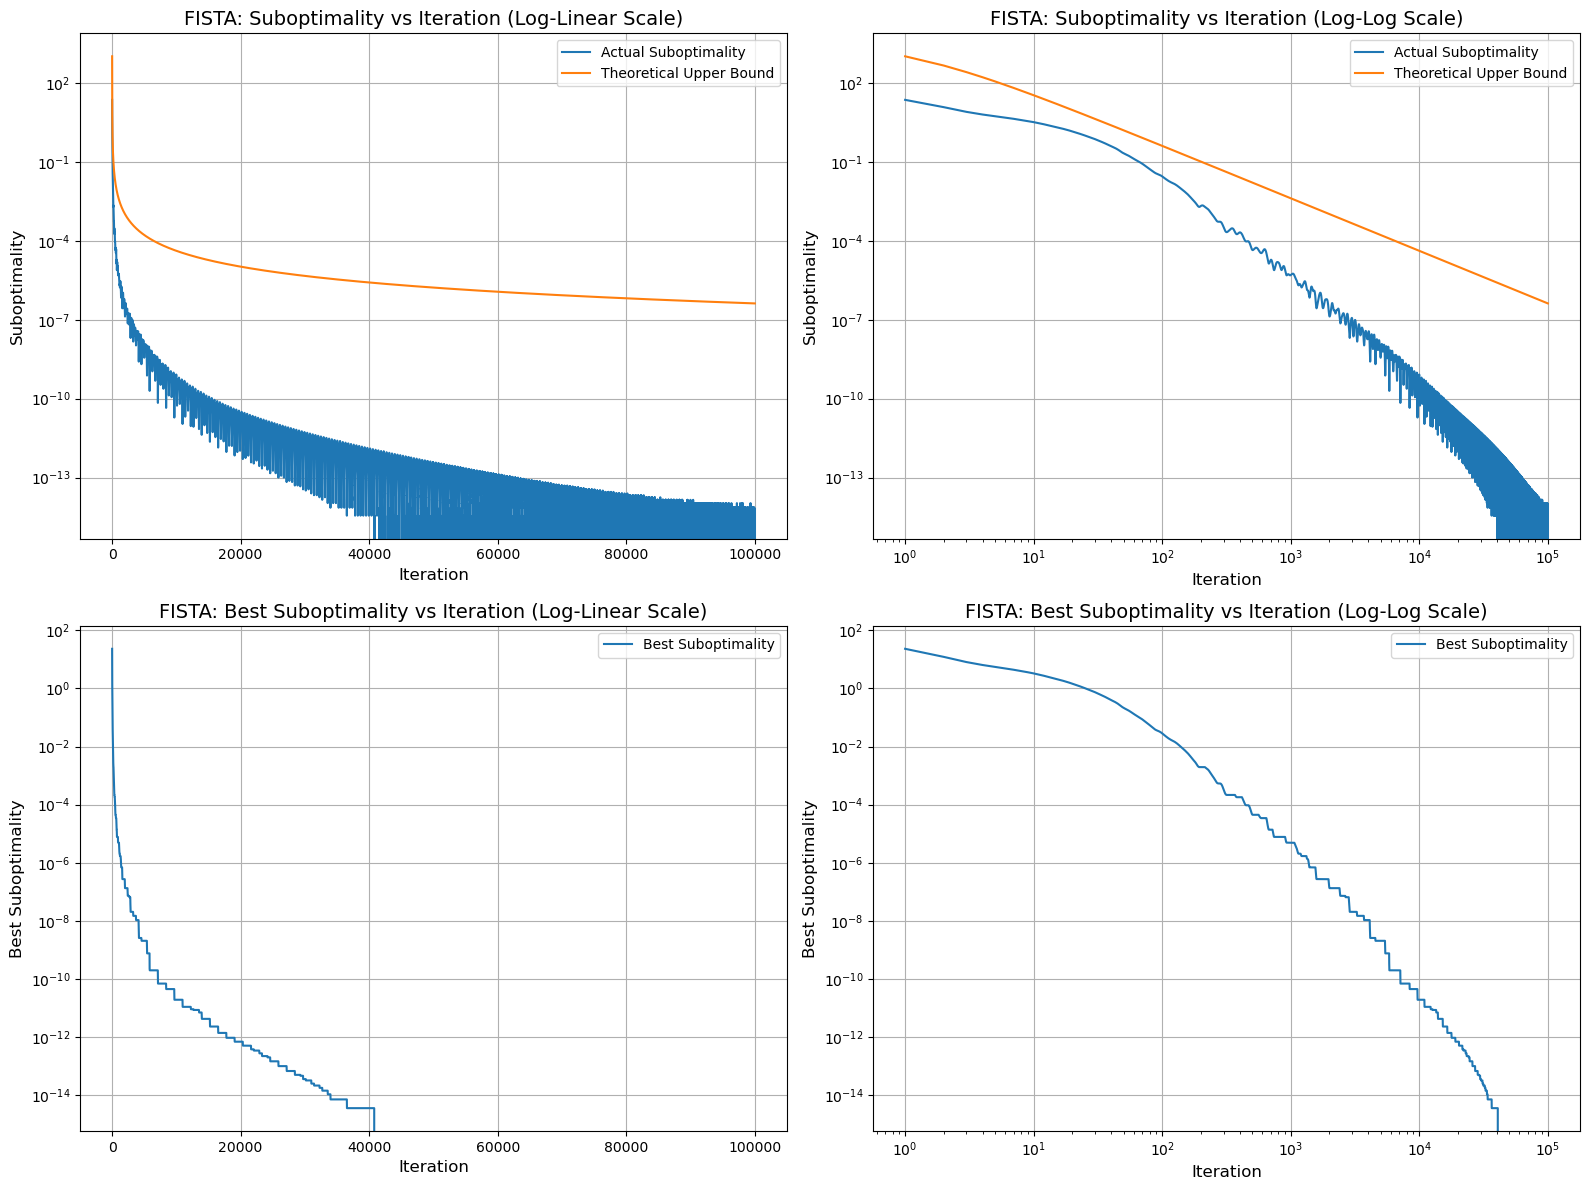

In [8]:
suboptimality, best_suboptimality = track_suboptimality(F_trajectory, x_opt_cvxpy, A, b, lambda_reg)
plot_suboptimality(suboptimality, best_suboptimality, "FISTA", x_opt_cvxpy)

### A Theorem on the Rate of Convergence
We state theorem 4.4 from the FISTA paper that will be used in the discussion of the results. 

**Theorem 4.4** Let $\left\{\mathbf{x}_{k}\right\}$ be generated by FISTA. Then for any $k \geq 1$

$$
\begin{equation*}
F\left(\mathbf{x}_{k}\right)-F\left(\mathbf{x}^{*}\right) \leq \frac{2 \alpha L(f)\left\|\mathbf{x}_{0}-\mathbf{x}^{*}\right\|^{2}}{(k+1)^{2}} \ \forall \mathbf{x}^{*} \in X_{*},
\end{equation*}
$$

where $\alpha=1$ for the constant stepsize setting and $\alpha=\eta$ for the backtracking stepsize setting.


In our set up we have a constant stepsize, so $\alpha = 1$ and $\mathrm{x}_{0} = \mathbf{0}$ so we have

$$
\begin{equation*}
F\left(\mathbf{x}_{k}\right)-F\left(\mathbf{x}^{*}\right) \leq \frac{2 L(f)\left\|\mathbf{x}^{*}\right\|^{2}}{(k+1)^{2}} \ \forall \mathbf{x}^{*} \in X_{*}
\end{equation*}.
$$
More importantly we have 

$$
\begin{equation*}
F\left(\mathbf{x}_{k}\right)-F\left(\mathbf{x}^{*}\right) =  \mathcal{O}\left(\frac{1}{k^2}\right)
\end{equation*}.
$$

We should mention that the assumptions used in the paper are the following:
- $g: \mathbb{R}^{n} \rightarrow \mathbb{R}$ is a continuous convex function which is possibly nonsmooth.
- $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ is a smooth convex function of the type $C^{1,1}$, i.e., continuously differentiable with Lipschitz continuous gradient $L(f)$ ($\beta$- smoothness). 
- The problem is solvable, i.e., $X_{*}:=\underset{x \in \mathbb{R}^n}{\text{Argmin}} \  F(x) \neq \emptyset$.

### Discussion

From the suboptimality plots, we observe that the convergence rates are indeed sublinear. The paper specifies the worst-case scenario as:

$$
F\left(\mathbf{x}_{k}\right) - F\left(\mathbf{x}^{*}\right) = \mathcal{O}\left(\frac{1}{k^2}\right),
$$

which seems accurate for small $k$, as indicated by the negative slope of approximately $-2$ in the log-log plot. However, this analysis may be somewhat misleading. The expected $\mathcal{O}\left(\frac{1}{k^2}\right)$ behavior is typically observed for very large $k$, but for larger values of $k$, the log-log plot appears to have a slope closer to $-4$, suggesting a rate of $\mathcal{O}\left(\frac{1}{k^4}\right)$.

I am not entirely certain why this faster rate appears, but it could be attributed to the specific structure of the problem, with $f(x) = \|Ax - b\|_2^2$ and $g(x) = \lambda \|x\|_1$. Recall that the $\mathcal{O}\left(\frac{1}{k^2}\right)$ result is a worst-case guarantee for general functions that satisfy the assumptions in the paper. For example, $f(x) = \|Ax - b\|_2^2$ is more regular than an arbitrary function in the Hölder space $C^{1,1}(\mathbb{R}^n)$, which is the class assumed in the paper. In fact, we have $f(x) \in C^{\infty,1}(\mathbb{R}^n)$. While I am not claiming this is the exact reason for the improved convergence rate, it is possible that problem-specific characteristics lead to better rates. Again, the $\mathcal{O}\left(\frac{1}{k^2}\right)$ is a worst-case bound.

Most importantly, we observe from the plot that the suboptimality satisfies the upper bound.


## Adaptive proximal gradient method

<div style="border: 2px solid black; padding: 10px; background-color: #f9f9f9;">

**Algorithm 3: Adaptive proximal gradient method**

**Input:** $x^0 \in \text{dom} \ g$, $\theta_0 = \frac{1}{3}$, $\alpha_0 > 0$

1. $x^1 = \text{prox}_{\alpha_0 g}(x^0 - \alpha_0 \nabla f(x^0))$

2. **For** $k = 1, 2, \dots$, do:

   $$ 
   L_k = \frac{\|\nabla f(x^k) - \nabla f(x^{k-1})\|}{\|x^k - x^{k-1}\|}
   $$

3. $$ 
   \alpha_k = \min \left\{ \sqrt{\frac{2}{3} + \theta_{k-1}} \alpha_{k-1}, \ \frac{\alpha_{k-1}}{\sqrt{[2\alpha_{k-1}^2 L_k^2 - 1]_+}} \right\}
   $$

4. $$ 
   x^{k+1} = \text{prox}_{\alpha_k g}(x^k - \alpha_k \nabla f(x^k))
   $$

5. $$ 
   \theta_k = \frac{\alpha_k}{\alpha_{k-1}}
   $$

</div>


**Initial stepsize.** The algorithm requires an initial stepsize $\alpha_0$. As is proved in the paper, the algorithm converges for any value $\alpha_0 > 0$ with the rate

$$
\min_{i \in [k]} (F(x^i) - F(x^*) \leq \frac{R^2}{2 \sum_{i=1}^k \alpha_i},
$$
where $R$ is defined as
$$
\begin{equation*}
R^{2}=\left\|x^{0}-x^{*}\right\|^{2}+2 \alpha_{0}^{2}\left\|\widetilde{\nabla} F\left(x^{0}\right)\right\|^{2}+\alpha_{0}\left(F\left(x^{0}\right)-F(x^*)\right),
\end{equation*}
$$
and 
$$
\widetilde{\nabla} F\left(x^{k}\right)=\nabla F\left(x^{k}\right)+\widetilde{\nabla} g\left(x^{k}\right),
$$
where $\widetilde{\nabla} g\left(x^{k+1}\right)$ is a certain subgradient of $g$ at $x^{k+1}$.

However,the choice of $\alpha_0$ will impact further steps due to the bound $\alpha_k \leq \sqrt{\frac{2}{3}+ \theta_{k-1}}  \alpha_{k-1}$. Because of this reason, we do not want to choose $\alpha_0$ too small. On the other hand, too large $\alpha_0$ will make $R$ large. To counterbalance these two extremes, the authors of the paper suggest the following:

$$
\text{choose } \alpha_0 \text{ such that } \alpha_0 L_1 \in \left[ \frac{1}{\sqrt{2}}, 2 \right]. 
$$

Other than this the implementation is straight forward, with the use of the previously implemented helpers. We implement the algorithm below.

In [9]:
def alpha_0_search(x_0, A, b, alpha_guess, lambda_reg):
    """
    Search for an initial step size alpha_0 that satisfies the condition alpha_0 * L_1 in [1/sqrt(2), 2].
    
    Args:
    x_0 (ndarray): Initial point
    A, b (ndarray): Problem data
    alpha_guess (float): Initial guess for alpha_0
    lambda_reg (float): Regularization parameter
    
    Returns:
    float: Suitable initial step size alpha_0
    """
    z = x_0 - alpha_guess * grad_f(x_0, A, b)
    x_1 = prox_g(z, alpha_guess, lambda_reg)
    L_1 = next_L_k(x_1, x_0, A, b)
   
    if alpha_guess * L_1 >= 1/np.sqrt(2) and alpha_guess * L_1 < 2:
        return alpha_guess
    elif alpha_guess * L_1 < 1/np.sqrt(2): # Recursion if condition not satisfied
        return alpha_0_search(x_0, A, b, alpha_guess*2, lambda_reg)
    else: # Recursion if condition not satisfied
        return alpha_0_search(x_0, A, b, alpha_guess/2, lambda_reg)

def next_L_k(x_k, x_k_old, A, b):
    """
    Compute the next local Lipschitz constant estimate.
    
    Args:
    x_k, x_k_old (ndarray): Current and previous iterates
    A, b (ndarray): Problem data
    
    Returns:
    float: Estimated local Lipschitz constant
    """
    return np.linalg.norm(grad_f(x_k, A, b) - grad_f(x_k_old, A, b)) / np.linalg.norm(x_k - x_k_old)

def next_alpha_k(alpha_old, theta_old, L_k):
    """
    Compute the next step size alpha_k.
    
    Args:
    alpha_old (float): Previous step size
    theta_old (float): Previous theta value
    L_k (float): Current local Lipschitz constant estimate
    
    Returns:
    float: Next step size alpha_k
    """
    arg_1 = np.sqrt((2/3) + theta_old) * alpha_old
    arg_2 = alpha_old / np.sqrt(np.max([0, 2 * alpha_old**2 * L_k**2 - 1])) # dividing by zero is fine here, since we will get inf
    return np.min([arg_1, arg_2])

def adaptive_proximal_gradient_descent(A, b, lambda_reg, alpha_guess, iterations=10000):
    """
    Implement the adaptive proximal gradient descent algorithm.
    
    Args:
    A, b (ndarray): Problem data
    lambda_reg (float): Regularization parameter
    alpha_guess (float): Initial guess for alpha_0
    iterations (int): Maximum number of iterations
    
    Returns:
    tuple: (x_k, F_trajectory) - Final solution and objective function trajectory
    """
    x_k = np.zeros(A.shape[1])
    F_trajectory = [compute_F(x_k, A, b, lambda_reg)]
   
    # Initialize alpha_0 using the search function
    
    alpha_k = alpha_0_search(x_k, A, b, alpha_guess, lambda_reg)
    alpha_0 = alpha_k
    theta_k = 1/3
   
    # First iteration
    x_k_old = x_k.copy()
    z = x_k - alpha_k * grad_f(x_k, A, b)
    x_k = prox_g(z, alpha_k, lambda_reg)
    F_trajectory.append(compute_F(x_k, A, b, lambda_reg))

    for _ in range(1, iterations):
        # Compute local Lipschitz constant estimate
        L_k = next_L_k(x_k, x_k_old, A, b)
        
        # Update step size
        alpha_k_old = alpha_k
        alpha_k = next_alpha_k(alpha_k, theta_k, L_k)
       
        # Proximal gradient step
        x_k_old = x_k.copy()
        z = x_k - alpha_k * grad_f(x_k, A, b)
        x_k = prox_g(z, alpha_k, lambda_reg)
        F_trajectory.append(compute_F(x_k, A, b, lambda_reg))
       
        # Update theta_k
        theta_k = alpha_k / alpha_k_old
    
    return x_k, F_trajectory, alpha_0

In [10]:
x_opt, F_trajectory, alpha_0= adaptive_proximal_gradient_descent(A, b, lambda_reg, 1, iterations=20000)

C:\Users\Ali\AppData\Local\Temp\ipykernel_10956\1953613585.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  arg_2 = alpha_old / np.sqrt(np.max([0, 2 * alpha_old**2 * L_k**2 - 1])) # dividing by zero is fine here, since we will get inf


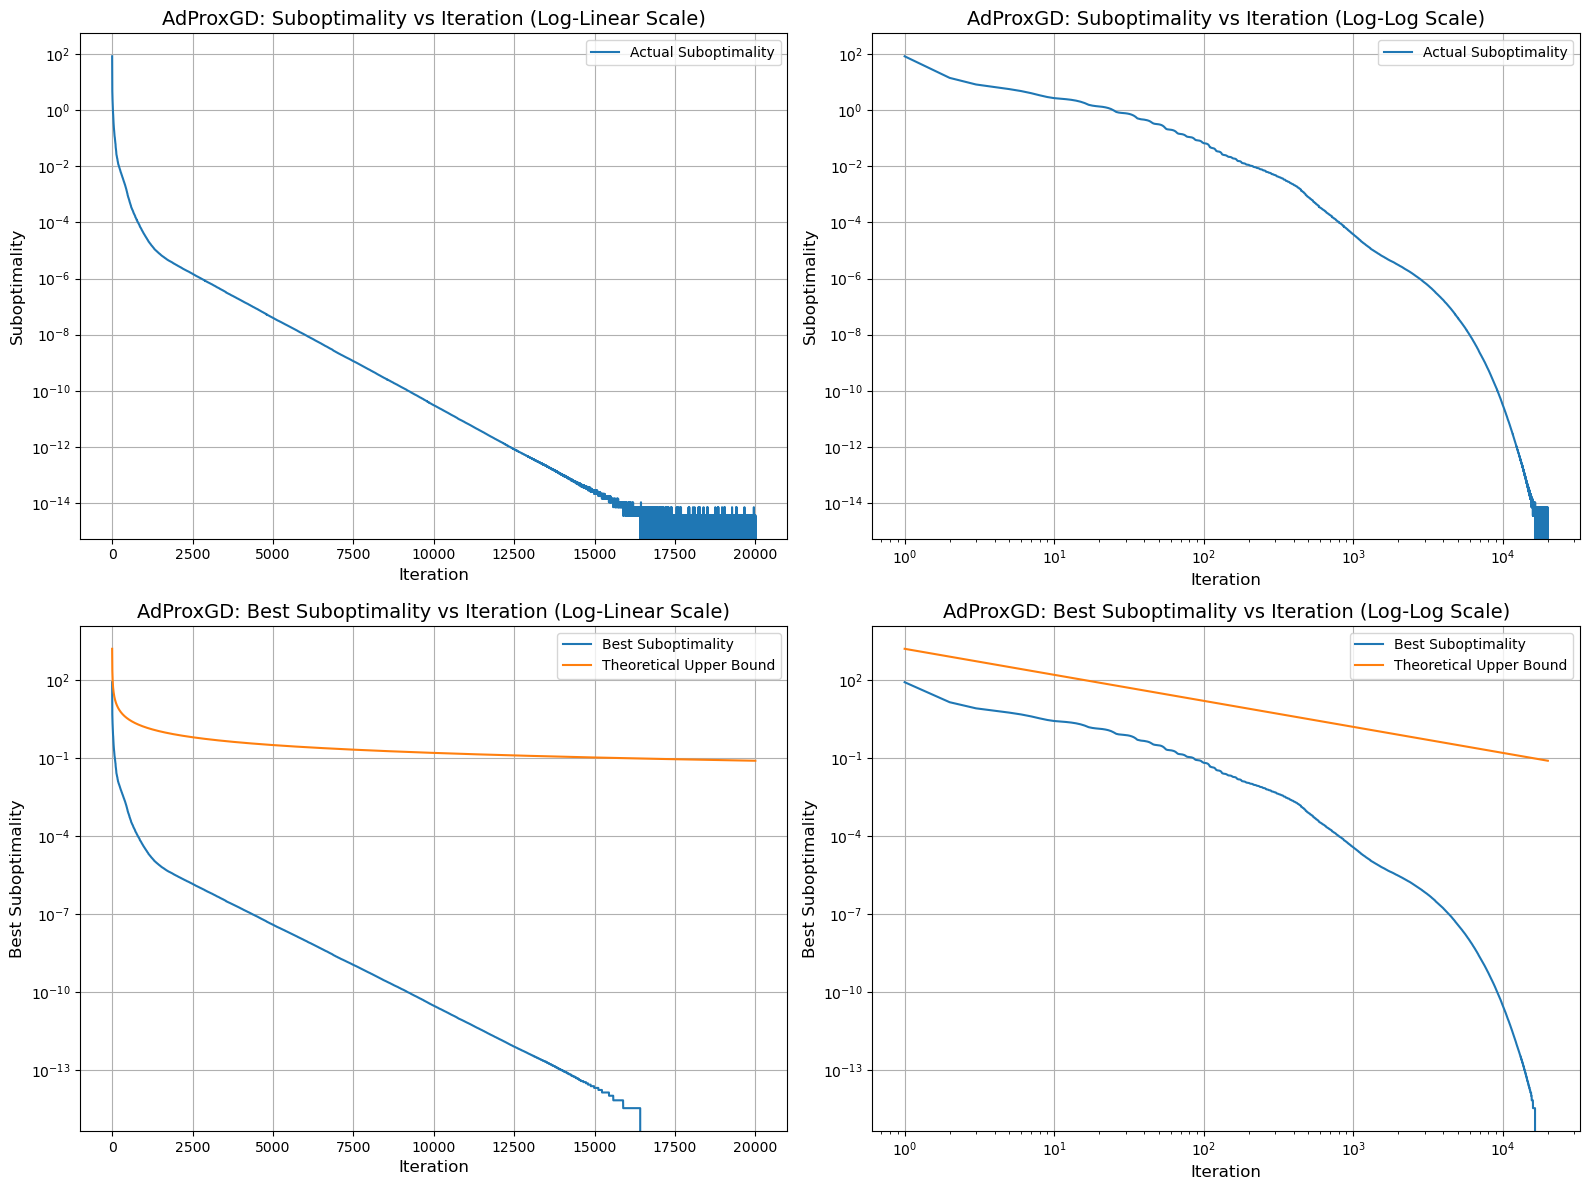

In [11]:
suboptimality, best_suboptimality = track_suboptimality(F_trajectory, x_opt_cvxpy, A, b, lambda_reg)
plot_suboptimality(suboptimality, best_suboptimality, "AdProxGD", x_opt_cvxpy, alpha_0= alpha_0)

### A Theorem on the Rate of Convergence and an Interesting remark
Here we restate theorem 3 and remark 6 of the AdProxGD paper.

**Theorem 3.** Let $f$ be differentiable and convex with a locally Lipschitz gradient $\nabla f$ and $g$ be convex lower semi-continuous. Then the sequence ( $x^{k}$ ) generated by Algorithm 3 converges to a solution and

$$
\begin{equation*}
\min _{i \in[k]}\left(F\left(x^{i}\right)-F(x^*)\right) \leqslant \frac{R^{2}}{2 \sum_{i=1}^{k} \alpha_{i}}.
\end{equation*}
$$

In particular, if $\alpha_{0}$ satisfies $\alpha_0 L_1 \in \left[ \frac{1}{\sqrt{2}}, 2 \right]$, then

$$
\begin{equation*}
\min _{i \in[k]}\left(F\left(x^{i}\right)-F(x^*)\right) \leqslant \frac{L R^{2}}{\sqrt{2} k},
\end{equation*}
$$
where $L$ is the Lipschitz constant of $\nabla f$ over $B\left(x^{*}, R\right)$ (our $\nabla f$ is Lipschitz continous everywhere, therefore $L$ is always the same).

Note that we indeed chose $\alpha_0$ satisfying $\alpha_0 L_1 \in \left[ \frac{1}{\sqrt{2}}, 2 \right]$, and we have implemented this upper bound in the plot. This theorem therefore suggests
$$
\begin{equation*}
\min _{i \in[k]}\left(F\left(x^{i}\right)-F(x^*)\right) = \mathcal{O}\left(\frac{1}{k}\right),
\end{equation*}
$$

We would also like emphasize remark 6:

**Remark 6.** "We didn't derive a linear convergence of the adaptive proximal gradient, when $F$ is strongly convex. We only mention that it is quite straightforward and goes along the same lines as the original AdGD in [MM20, Theorem 2] in the strongly convex regime."



### Discussion

The results of this algorithm are quite interesting. We see in the plot that we get rapid convergence, and after around 16,000 iterations, it has already reached the same optimum as CVXPY, compared to FISTA's 40,000 iterations. Before convergence, we observe what resembles a linear convergence rate, which is better than the sublinear rate seen in FISTA. The theory would suggest a much slower $\mathcal{O}\left(\frac{1}{k}\right)$ for the best-so-far suboptimality, but this also shows a linear convergence rate. Again, the faster convergence rate compared to theory is likely due to the specifics of the Lasso problem.

Remark 6 states that for strongly convex objective functions, we would expect a linear convergence rate, which is typical for proximal gradient methods. While our objective function is not strongly convex, this could suggest that sufficient regularity of the objective function leads to better rates, even though it is not strictly strongly convex. For example, the paper assumes only local Lipschitz continuity of $\nabla f$, whereas $\nabla f(x) = \nabla \|Ax - b\|_2^2$ is Lipschitz continuous everywhere.

Again, the most important observation is that our best-so-far suboptimality (which is the focus of this paper) satisfies the theoretical upper bound. Clearly, in the plot above, the upper bound is respected. Another interesting point is that this algorithm appears less noisy when the suboptimality becomes small, compared to FISTA.

In terms of determining which algorithm is superior for the Lasso problem, one would need to perform extensive testing, measuring the time taken by the algorithms to converge below a certain tolerance for many differently generated $A$ and $b$. This is outside the scope of this notebook.
